In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import torch
import torch.nn as nn
from tqdm import tqdm
import csv
import matplotlib.pyplot as plt
import gymnasium as gym

from FFNN import FFNN
from blackjackenv_extended import BlackjackEnv

from random_agent import RandomAgent
from basic_strategy_agent import BasicStrategyAgent
from backprop_agent import BackpropAgent
from FFNN_agent import FFNNAgent
from DQFFNN_BJ_agent import DQFFNNAgentBJ
from DQFFNN_agent import DQFFNNAgent

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("using gpu: ", torch.cuda.get_device_name())
else:
    device = torch.device('cpu')
    print("using cpu")

seed = 37
np.random.seed(seed)

c:\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


using cpu


## Blackjack

In [3]:
env = BlackjackEnv(natural=True)

episodes = 100 #75000
collect_data = True

In [2]:
KEY = {0: 'STAND', 1:'HIT', 2:'DOUBLE', 3: 'SPLIT'}

def one_hot_encode(observation, n):
    one_hot = np.zeros(n)
    one_hot[observation] = 1
    return one_hot

def play_game(env, episodes, agent, collect_data=False, print_rewards=True, OH_encode=False):
    rewards = []

    for episode in tqdm(range(episodes)):
        observation, info = env.reset()
        done = False
        
        # print(f"Episode: {episode+1}/{episodes}")
        # print("-"*40)
        # print("hand 1", env.player)
        # print("hand 2", env.player2)
        # print("Start Observation: ", observation)
        
        
        while not done:
            if OH_encode:
                observation = one_hot_encode(observation, env.observation_space.n)
            
            action = agent.get_action(observation)
            #print("Action: ", KEY[action])

            # save data for training
            if collect_data:
                agent.collect_data(observation, action)
            
            next_observation, reward, terminated, truncated, info = env.step(action) 
            
            if OH_encode:
                agent.learn(observation, 
                            action, 
                            reward, 
                            one_hot_encode(next_observation, env.observation_space.n), 
                            terminated or truncated)
            else:  
                agent.learn(observation, action, reward, next_observation, terminated or truncated)
            observation = next_observation
            
            # print("hand 1", env.player)
            # print("hand 2", env.player2)
            # print("Observation: ", observation, "Reward: ", reward)
            

            if terminated or truncated:
                # print(f"Dealer hand: ", env.dealer)
                rewards.append(reward)
                observation = env.reset()
                done = True
        
        agent.decay_epsilon()    

    if collect_data:
        agent.save_data()
    
    average_reward = sum(rewards)/episodes
    variance = sum([((x - average_reward) ** 2) for x in rewards]) / (episodes - 1)

    if print_rewards:
        #print("Rewards: ", rewards)
        print("Average Reward: ", average_reward)
        print("Variance: ", variance)
    
    return rewards

In [4]:
def plot_reward(data, title, filename, labels, plot_variance=False, rolling_length=1000):
    data = np.array(data)
    np.savetxt(f'../data/{filename}_rewards.csv', data.reshape(data.shape[0], -1), delimiter=',')
    
    _, ax = plt.subplots()
    
    rolling_mean = np.zeros((len(data), len(data[0]) - (rolling_length - 1))) 
    for i in range(len(data)):
        rolling_mean[i] = (np.convolve(np.array(data[i]).flatten(), np.ones(rolling_length), mode="valid")
            / rolling_length)
            
    if plot_variance:
        mean = rolling_mean.mean(axis=0)
        variance = rolling_mean.var(axis=0)
        upper_bound_sd = mean + np.sqrt(variance)
        lower_bound_sd = mean - np.sqrt(variance)
        plt.plot(mean, label='Mean', color='blue')
        plt.fill_between(range(len(mean)),upper_bound_sd, lower_bound_sd, alpha=0.2, label='Standard Deviation')
    else:
        for i in range(len(data)):
            ax.plot(rolling_mean[i], label=labels[i])

    plt.ylabel("Reward")
    plt.xlabel("Episodes")
    plt.legend()
    plt.savefig(f"../figures/{filename}_rewards.png", dpi='figure', format=None)
    plt.show()

### Random & Basic Agents

100%|██████████| 100/100 [00:00<00:00, 7644.35it/s]


Average Reward:  -0.62
Variance:  1.5056565656565657


100%|██████████| 100/100 [00:00<00:00, 7815.57it/s]

Average Reward:  -0.13
Variance:  1.230404040404041


ValueError: negative dimensions are not allowed

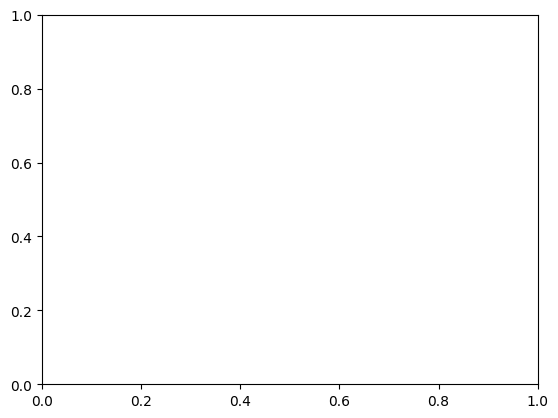

In [5]:
agent = RandomAgent(env, filename="random_agent")
rewards_random = play_game(env, episodes, agent, collect_data)


agent = BasicStrategyAgent(env, filename="basic_strategy_agent")
rewards_basic_strategy = play_game(env, episodes, agent, collect_data)
plot_reward([rewards_random, rewards_basic_strategy], "Random vs Basic Strategy Agent", "random_basic_strategy", ["Random Agent", "Basic Strategy Agent"])

## Data Generation

### Simulated Data

In [4]:
def read_data(file):
    return pd.read_csv(file, delimiter=',')

In [5]:
def split_data(data):
    x = data[:, :5]
    y = data[:, 5]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
    return x_train, x_test, y_train, y_test

def transform(data):
    data = torch.tensor(data, dtype=torch.float32)
    return data

In [6]:
def preprocess(filename):
    df_raw = read_data(filename)
    print(df_raw.head())
    d_raw = df_raw.to_numpy() # data to binary?
    x, x_test, y, y_test = split_data(d_raw)
    x, x_test = transform(x), transform(x_test)
    
    return x, x_test, y, y_test

In [7]:
datafile = '../data/basic_strategy_agent.csv'
x_train, x_test, y_train, y_test = preprocess(datafile)

   Player sum  Dealer card  Usable ace  Double down allowed  Split allowed  \
0          12           10           0                    1              0   
1          21           10           0                    0              0   
2          19            5           0                    1              0   
3          10            8           0                    1              0   
4          20            4           0                    1              1   

   Action  
0       1  
1       0  
2       0  
3       2  
4       0  


In [8]:
def one_hot_encode(y, n):
    return torch.eye(n)[y]

def combine_input_and_label(x, y, n):
    y_one_hot = one_hot_encode(y, n)
    return torch.concat((x, y_one_hot), 1)

def generate_neg_labels(y, n):
    y_ = y.copy()
    for i in range(len(y)):
        negative_labels = [j for j in range(n) if j != y[i]]
        y_[i] = np.random.choice(negative_labels)

    return y_

In [9]:
x_pos = combine_input_and_label(x_train, y_train, 4)

y_neg = generate_neg_labels(y_train, 4)
x_neg = combine_input_and_label(x_train, y_neg, 4)

y_train_OH = one_hot_encode(y_train, 4)
y_test_OH = one_hot_encode(y_test, 4)

print(f"x_pos[0]: {x_pos[0]}")
print(f"x_neg[0]: {x_neg[0]}")
print(f"Train size: {len(x_train)}")
print(f"Test size: {len(x_test)}")

x_pos[0]: tensor([16., 10.,  0.,  0.,  0.,  0.,  1.,  0.,  0.])
x_neg[0]: tensor([16., 10.,  0.,  0.,  0.,  1.,  0.,  0.,  0.])
Train size: 120
Test size: 31


### Balanced Data

In [10]:
env = BlackjackEnv(natural=True)
basic_strategy_agent = BasicStrategyAgent(env, filename='../data/blackjack_combinations')

def create_combinations():
    for player_hand in range(4, 22):
        for dealer_hand in range(2, 12):
            for usable_ace in range(2):
                for can_double_down in range(2):
                    for can_split in range(2):
                        observation = (player_hand, dealer_hand, usable_ace, can_double_down, can_split)
                        if (dealer_hand == 11 and usable_ace) == 1:
                            # impossible combination    
                            continue
                        action = basic_strategy_agent.get_action(observation)
                        basic_strategy_agent.collect_data(observation, action)
    
    basic_strategy_agent.save_data()
                        
            
def get_combinations_for_action(action):
    samples = []
    with open('../data/blackjack_combinations.csv', 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            if int(row[-1]) == action:
                samples.append(row)
    return samples

def sample_balanced_data(n_samples):
    data = []
    combinations = np.empty(4, dtype=object)
    
    for action in range(4):
        combinations[action] = get_combinations_for_action(action)
        
        for i in range(n_samples):
            sample_idx = np.random.choice(len(combinations[action]))
            data.append(combinations[action][sample_idx])

    with open('../data/balanced_data.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        
        writer.writerow(["Player sum", "Dealer card", "Usable ace", "Double down allowed", "Split allowed", "Action"])
        writer.writerows(data)

In [13]:
create_combinations()
samples_per_action = 1000
sample_balanced_data(samples_per_action)

In [14]:
datafile = '../data/balanced_data.csv'
x_train_bal, x_test_bal, y_train_bal, y_test_bal = preprocess(datafile)

x_pos_bal = combine_input_and_label(x_train_bal, y_train_bal, 4)

y_neg_bal = generate_neg_labels(y_train_bal, 4)
x_neg_bal = combine_input_and_label(x_train_bal, y_neg_bal, 4)

y_train_OH_bal = one_hot_encode(y_train_bal, 4)
y_test_OH_bal = one_hot_encode(y_test_bal, 4)


print(f"\nx_pos[0]: {x_pos_bal[0]}")
print(f"x_neg[0]: {x_neg_bal[0]}")
print(f"\nTrain size: {len(x_train_bal)}")
print(f"Test size: {len(x_test_bal)}")

   Player sum  Dealer card  Usable ace  Double down allowed  Split allowed  \
0          20           10           0                    1              0   
1          21            4           1                    1              1   
2          13            2           0                    1              1   
3          20           11           0                    1              0   
4          17            6           0                    1              1   

   Action  
0       0  
1       0  
2       0  
3       0  
4       0  

x_pos[0]: tensor([8., 3., 1., 0., 1., 0., 1., 0., 0.])
x_neg[0]: tensor([8., 3., 1., 0., 1., 0., 0., 1., 0.])

Train size: 3200
Test size: 800


## Forward-Forward

In [11]:
def print_accuracy(model_predictions, y):
    predictions = np.array(torch.Tensor.cpu(model_predictions)).flatten()
    accuracy =  model_predictions.eq(torch.from_numpy(y).to(device)).float().mean().item()
    
    print(y)
    print(predictions)
    print(f'Accuracy: {accuracy}')

    ConfusionMatrixDisplay.from_predictions(y, predictions, normalize="true")
    
def plot_accuracy(data, title, filename):
    np.savetxt(f'../data/{filename}_accuracy.csv', data, delimiter=',')

    plt.plot(np.array(data))

    plt.ylabel("Accuracy (%)")
    plt.xlabel("Epochs")
    plt.savefig(f"../figures/{filename}_accuracy.png", dpi='figure', format=None)
    plt.show()

### Balanced Data FFNN

In [16]:
# Hyperparameters
layers = [9, 2000, 2000, 2000, 2000]
threshold = 5
learning_rate = 0.001
epochs = 240
batch_size = 64
lr_decay = False

model = FFNN(
    device=device,
    layers=layers,
    threshold=threshold,
    learning_rate=learning_rate,
    epochs=epochs,
    batch_size=batch_size,
    lr_decay=lr_decay,
    ).to(device)


In [24]:
last_layer_accuracy = model.train(x_pos_bal, x_neg_bal)
model.save_model('../models/model_balanced.pth')


Training Layer: 1
----------------------------------------


100%|██████████| 240/240 [00:23<00:00, 10.20it/s]



Training Layer: 2
----------------------------------------


  5%|▍         | 11/240 [00:33<11:29,  3.01s/it]


KeyboardInterrupt: 

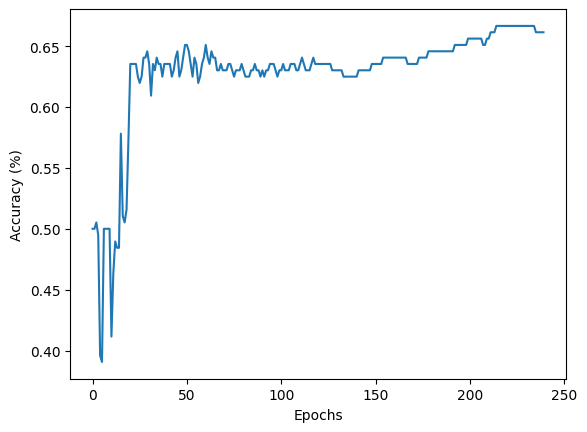

[1 2 3 3 2 3 0 0 0 2 2 0 3 1 1 3 1 1 2 1 3 3 3 3]
[1 2 1 2 2 2 3 0 3 2 2 0 1 2 1 1 1 2 2 0 2 1 2 2]
Accuracy: 0.4166666567325592


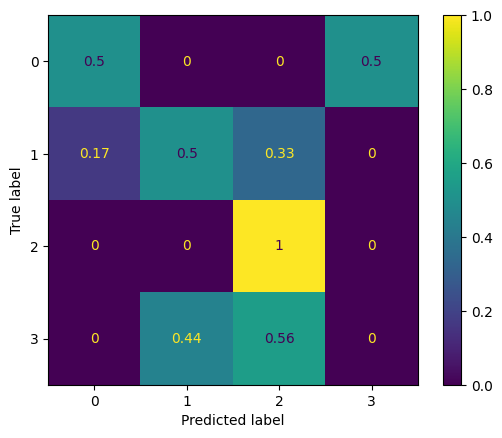

In [19]:
plot_accuracy(last_layer_accuracy, "Training Accuracy Last Layer Balanced Model", "model_balanced")
print_accuracy(model.predict_accumulated_goodness(x_test_bal.to(device)), y_test_bal)

### FFNN

In [17]:
def cross_validation(x_pos, x_neg,architectures, thresholds, learning_rates, n_epochs, n_folds, batch_sizes, lr_decays, save_accuracies=True):
    
    size_subset = len(x_pos) // n_folds
    validation_risks = []
    
    for architecture in architectures:
        for threshold in thresholds:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    for lr_decay in lr_decays:
                        #print("-"*40)
                        print(f"Current Model:{architecture}, thr={threshold}, lr={lr}, batch_size={batch_size}, lr_decay={lr_decay}")
                        val_risks_model = []
                        
                        for fold in range(n_folds):
                            #print(f"Fold {fold}")
                            #print("-"*40)
                            
                            # Split data into training and validation
                            start_idx = fold * size_subset
                            end_idx = (fold + 1) * size_subset
                            x_pos_train = torch.cat((x_pos[:start_idx], x_pos[end_idx:]))
                            x_neg_train = torch.cat((x_neg[:start_idx], x_neg[end_idx:]))
                            x_val = x_train[start_idx:end_idx]
                            y_val = y_train[start_idx:end_idx]
                            
                            # Initialize current model
                            model = FFNN(
                                device=device,
                                layers=architecture,
                                bias=True,
                                threshold=threshold,
                                learning_rate=lr,
                                epochs=n_epochs,
                                batch_size=batch_size,
                                lr_decay=lr_decay,
                                verbose=False
                            ).to(device)
                            
                            # Train model
                            last_layer_accuracy = model.train(x_pos_train, x_neg_train)
                            
                            # Compute validation risk
                            predictions = model.predict_accumulated_goodness(x_val.to(device))
                            val_risk = 1 - predictions.eq(torch.from_numpy(y_val).to(device)).float().mean().item()
                            val_risks_model.append(val_risk)
                            
                            if save_accuracies:
                                np.savetxt(f'../data/cxv/{architecture}_th={threshold}_lr={lr}_b={batch_size}_lrdecay={lr_decay}_accuracy{fold}.csv', 
                                           last_layer_accuracy, delimiter=','
                                           )
                            
                        avg_val_risk = np.mean(val_risks_model)
                        validation_risks.append((architecture, threshold, lr, batch_size, lr_decay, avg_val_risk ))
                        #model.save_model(f'../models/model_{architecture}_{threshold}_{lr}_{avg_val_risk}.pth')
                        
                        with open('../data/cxv_results.csv', 'a', newline='') as file:
                            writer = csv.writer(file)
                            writer.writerow([architecture, threshold, lr, batch_size, lr_decay, avg_val_risk])
                            
                        #print(f"validation risks for model {architecture}, thr={threshold}, lr={lr}: {val_risks_model}")
                        print(f"average validation risk: {avg_val_risk}")
                        print("-"*40)
    
    #print("total validation risks:" , validation_risks)  
    min_risk_model = min(validation_risks, key=lambda x: x[-1])
    print(f"Best model: {min_risk_model[:-1]}, with risk: {min_risk_model[-1]}")   
    return min_risk_model               

In [ ]:
# Hyperparameters
architectures = [
    [9,30,30,30,30],
    [9,100,100,100,100],
    [9,500,500,500,500],
    [9,2000,2000,2000,2000],
]
thresholds = [0.1, 0.5, 1, 5, 10]
learning_rates = [0.0001,0.001,0.01,0.03]
n_epochs = 240
n_folds = 2
batch_sizes = [32]
lr_decays = [0]

best_model = cross_validation(
    x_pos, 
    x_neg, 
    architectures,
    thresholds,
    learning_rates,
    n_epochs,
    n_folds,
    batch_sizes,
    lr_decays,
)

In [78]:
# Cross validate best models
best_models = [
    ([9,500,500,500,500], 0.1, 0.0001, 32, 0),
    ([9,500,500,500,500], 0.1, 0.0001, 32, 0),
    ([9,500,500,500,500], 0.1, 0.0001, 32, 0,),
]

for model in best_models:
    cross_validation(
        x_pos,
        x_neg,
        [model[0]],
        [model[1]],
        [model[2]],
        n_epochs,
        10,
        [model[3]],
        [model[4]],
    )

Current Model:[9, 500, 500, 500, 500], thr=0.1, lr=0.0001, batch_size=32, lr_decay=0


KeyboardInterrupt: 

In [12]:
# Best model hyperparameters
architecture_best = [9,500,500,500,500]
threshold_best = 0.5
learning_rate_best = 0.01
epochs = 240
batch_size = 32
lr_decay = 0

print(f"Best model: {architecture_best}, thr={threshold_best}, lr={learning_rate_best}, batch_size={batch_size}, lr_decay={lr_decay}")

model = FFNN(
    device=device,
    layers=architecture_best,
    threshold=threshold_best,
    learning_rate=learning_rate_best,
    epochs=epochs,
    batch_size=batch_size,
    lr_decay=lr_decay
).to(device)

Best model: [9, 500, 500, 500, 500], thr=0.5, lr=0.01, batch_size=32, lr_decay=0


In [19]:
last_layer_accuracy = model.train(x_pos, x_neg)
model.save_model('../models/best_model.pth')


Training Layer: 1
----------------------------------------


100%|██████████| 240/240 [00:00<00:00, 294.80it/s]



Training Layer: 2
----------------------------------------


100%|██████████| 240/240 [00:02<00:00, 104.94it/s]



Training Layer: 3
----------------------------------------


100%|██████████| 240/240 [00:02<00:00, 118.86it/s]



Training Layer: 4
----------------------------------------


100%|██████████| 240/240 [00:02<00:00, 96.96it/s] 


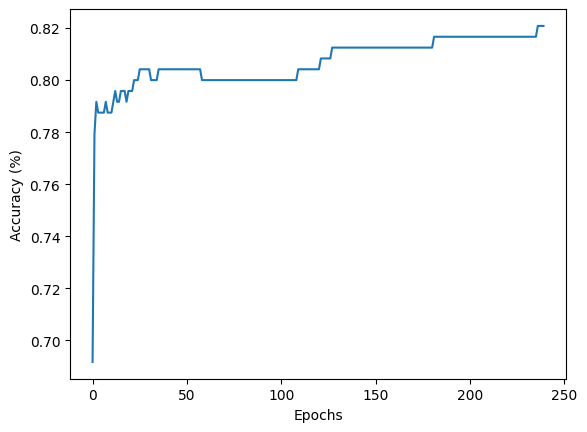

[0 1 0 2 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 2 1 1 1 1 3 2]
[0 1 0 1 3 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 0 1 1]
Accuracy: 0.5806451439857483


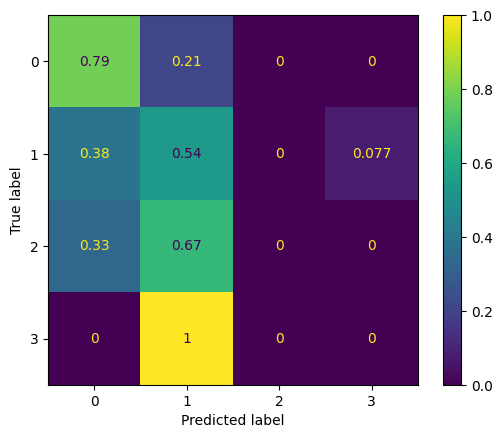

In [20]:
plot_accuracy(last_layer_accuracy, "Training Accuracy Last Layer Best Model", "best_model")
print_accuracy(model.predict_accumulated_goodness(x_test.to(device)), y_test)


### FFNN with Softmax Classifier

In [13]:
# Create equal model with classifier
model = FFNN(
    device=device,
    layers=architecture_best,
    threshold=threshold_best,
    learning_rate=learning_rate_best,
    epochs=epochs,
    batch_size=batch_size,
    lr_decay=lr_decay,
    classifier=True
).to(device)

model.load_model('../models/best_model.pth')

In [16]:
classifier_layer_accuracy = model.train_classifier(x_train.to(device), y_train_OH.to(device), epochs, batch_size)
torch.save(model.classifier.state_dict(), '../models/softmax_model_classifier.pth')


Training Softmax
----------------------------------------


100%|██████████| 240/240 [00:00<00:00, 566.82it/s]


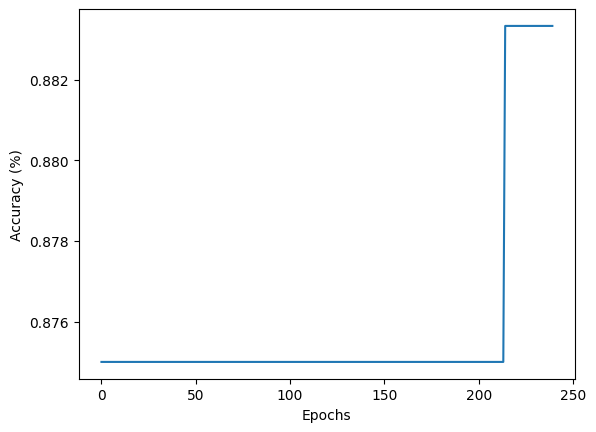

[0 1 0 2 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 2 1 1 1 1 3 2]
[0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 1]
Accuracy: 0.7096773982048035


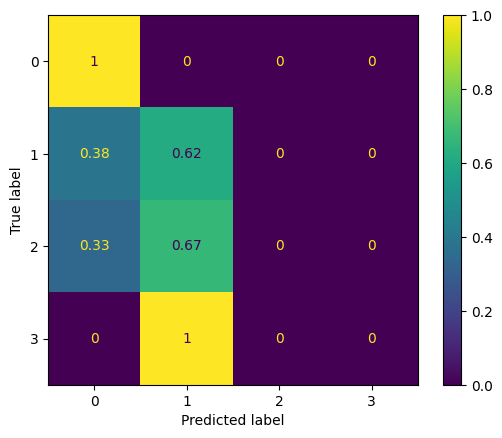

In [17]:
plot_accuracy(classifier_layer_accuracy, "Training Loss Classifier", "classifier")
print_accuracy(model.predict_classifier(x_test.to(device)),y_test)

## Backpropagation

In [19]:
def train(model, x, y, epochs, loss_function, optimizer, batch_size):
    
    model.train()
    num_batches = len(x) // batch_size
    
    total_accuracy = []
    for epoch in range(epochs):
        losses = []
        for batch in range(num_batches):
            start_idx = batch * batch_size
            end_idx = start_idx + batch_size
            
            x_batch = x[start_idx:end_idx]
            y_batch = y[start_idx:end_idx]
            
            predictions = model(x_batch)
            loss = loss_function(predictions, y_batch)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        accuracy = model(x).argmax(1).eq(torch.argmax(y, dim=1)).float().mean().item()   
        total_accuracy.append(accuracy)
        print(f"epoch: {epoch + 1}/{epochs} avg. loss: {sum(losses)/len(losses)}")
        
    return total_accuracy

In [20]:
def test(model, x_test, y_test, loss_function):
    
    model.eval()
    
    with torch.no_grad():
        predictions = model(x_test)
        test_loss = loss_function(predictions, y_test).item()
        
    print(f"avg. test loss: {test_loss}")   
    
def predict_actions(model, x):
    model.eval()
    
    with torch.no_grad():
        predictions = model(x)
        return predictions.argmax(1)

In [21]:
from backpropNN import BackpropNN

input_size = 5
output_size = 4

# hyperparameters
hidden_size = 30
activation_function = nn.ReLU()
epochs = 100
batch_size = 64
learning_rate = 0.001

# fully connected neural network with 4 hidden layers
backprop_model = BackpropNN(input_size, output_size, hidden_size, activation_function)

optimizer = torch.optim.Adam(backprop_model.parameters(), lr=learning_rate);
loss_fn = nn.CrossEntropyLoss()

In [22]:
# accuracy data opslaan

backprop_accuracy = train(backprop_model, x_train, y_train_OH, epochs, loss_fn, optimizer, batch_size)
torch.save(backprop_model.state_dict(), '../models/backprop_model.pth')

epoch: 1/100 avg. loss: 1.3821847438812256
epoch: 2/100 avg. loss: 1.360896348953247
epoch: 3/100 avg. loss: 1.3419750928878784
epoch: 4/100 avg. loss: 1.3248740434646606
epoch: 5/100 avg. loss: 1.3093758821487427
epoch: 6/100 avg. loss: 1.2952905893325806
epoch: 7/100 avg. loss: 1.2822929620742798
epoch: 8/100 avg. loss: 1.270348072052002
epoch: 9/100 avg. loss: 1.2599751949310303
epoch: 10/100 avg. loss: 1.2496628761291504
epoch: 11/100 avg. loss: 1.2390681505203247
epoch: 12/100 avg. loss: 1.2281625270843506
epoch: 13/100 avg. loss: 1.2169969081878662
epoch: 14/100 avg. loss: 1.2056280374526978
epoch: 15/100 avg. loss: 1.19382643699646
epoch: 16/100 avg. loss: 1.181567668914795
epoch: 17/100 avg. loss: 1.1688183546066284
epoch: 18/100 avg. loss: 1.1554957628250122
epoch: 19/100 avg. loss: 1.142006278038025
epoch: 20/100 avg. loss: 1.1283512115478516
epoch: 21/100 avg. loss: 1.1144574880599976
epoch: 22/100 avg. loss: 1.1004952192306519
epoch: 23/100 avg. loss: 1.0865213871002197
epo

In [152]:
test(backprop_model, x_test, y_test_OH, loss_fn)

avg. test loss: 0.755010724067688


In [23]:
plot_accuracy(backprop_accuracy, "Training Accuracy Backprop Model", "backprop_model")
accuracy = predict_actions(backprop_model, x_test).eq(torch.from_numpy(y_test)).float().mean().item()
print(accuracy)

[0.01666666753590107, 0.19166666269302368, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5249999761581421, 0.5166666507720947, 0.5166666507720947, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5083333253860474, 0.5166666507720947, 0.516666650772094

## FFNN Blackjack

### FFNN & Backpropagation

100%|██████████| 1500/1500 [00:01<00:00, 801.29it/s]


Average Reward:  -0.8273333333333334
Variance:  2.566897487213628


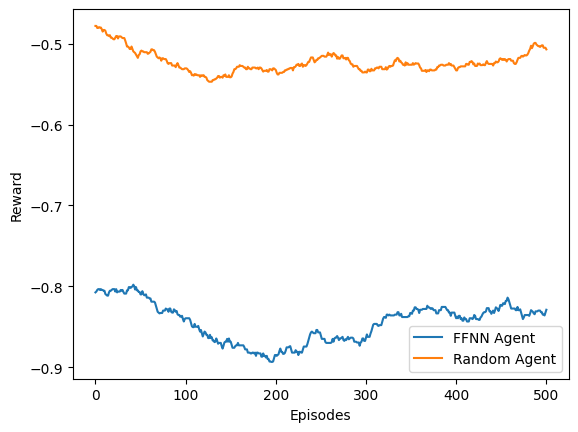

In [160]:
# FFNN hyperparameters
model_path = '../models/best_model.pth'
layers = best_model[0]
threshold = best_model[1]
lr = best_model[2]

agent = FFNNAgent(
    env,
    model_path=model_path,
    device=device,
    layers=layers,
    threshold=threshold,
    lr=lr,
    filename="ffnn_agent"
)

rewards_FFNN = play_game(env, episodes, agent, collect_data)
plot_reward([rewards_FFNN], "FFNN Agent", "ffnn_random_agent", ["FFNN Agent"])
plot_reward([rewards_FFNN, rewards_random], "FFNN Agent", "ffnn_random_agent", ["FFNN Agent", "Random Agent"])
plot_reward([rewards_FFNN, rewards_basic_strategy, rewards_random], "FFNN Agent", "ffnn_random_agent", ["FFNN Agent", "Basic Strategy Agent", "Random Agent"])

  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 1500/1500 [00:00<00:00, 3011.83it/s]


Average Reward:  -0.084
Variance:  0.9735930620413816


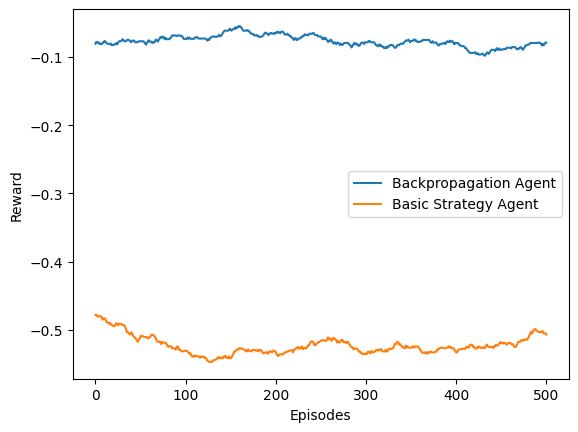

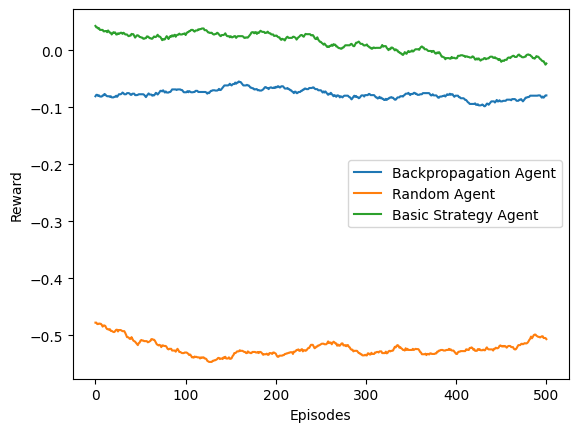

In [161]:
# Backprop hyperparameters
input_size = 5
output_size = 4
hidden_size = 30
activation_fn = nn.ReLU()

agent = BackpropAgent(
    env, 
    model=torch.load('../models/backprop_model.pth'),
    input_size=input_size, 
    output_size=output_size, 
    hidden_size=hidden_size, 
    activation_fn=activation_fn,
    filename="backprop_agent"
)

rewards_BP = play_game(env, episodes, agent, collect_data)
plot_reward([rewards_BP, rewards_random], "Backpropagation Agent", "backprop_random_agent", ["Backpropagation Agent", "Random Agent"])
plot_reward([rewards_BP, rewards_random, rewards_basic_strategy], "Backpropagation Agent", "backprop_random_basic_agent", ["Backpropagation Agent", "Random Agent", "Basic Strategy Agent"])

### DQFFL

In [163]:
# DQFFL hyperparameters
layers = [9,1000,1000,1000]
threshold = 0.5
lr = 0.001

#RL hyperparameters
episodes = 4000 
epsilon = 1.0
epsilon_decay = epsilon / (episodes / 2)
discount_factor = 0.99
batch_size = 32
update_td_target = 50
buffer_size = 10000

total_rewards = []
for i in range(5):
    print(f"\nRun {i+1}")
    print("-"*40)
    agent = DQFFNNAgentBJ(
        env,
        device=device,
        layers=layers,
        threshold=threshold,
        lr=lr,
        epsilon=epsilon,
        epsilon_decay=epsilon_decay,
        discount_factor=discount_factor,
        batch_size=batch_size,
        update_td_target=update_td_target,
        buffer_size=buffer_size,
        filename="dqffnn_agent"
    )
    rewards_DQFFNN = play_game(env, episodes, agent, collect_data, print_rewards=False)
    total_rewards.append(rewards_DQFFNN)
    
agent.model.save_model(path='../models/DQFFNN_model.pth')
plot_reward(total_rewards, "DQFFNN Agent", f"DQFFNN_agent_lr={lr}_df={discount_factor}_batch={batch_size}_update={update_td_target}_buffer={buffer_size}", ["DQFFNN Agent"], plot_variance=True, rolling_length=100)


Run 1
----------------------------------------


  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:09<00:00, 15.39it/s]



Run 2
----------------------------------------


100%|██████████| 150/150 [00:07<00:00, 18.92it/s]



Run 3
----------------------------------------


100%|██████████| 150/150 [00:07<00:00, 20.75it/s]



Run 4
----------------------------------------


100%|██████████| 150/150 [00:07<00:00, 20.99it/s]



Run 5
----------------------------------------


100%|██████████| 150/150 [00:07<00:00, 19.60it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

[0 0 0 1 0 0 1 0 1 2 0 1 1 1 0 0 0 1 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Accuracy: 0.5263158082962036


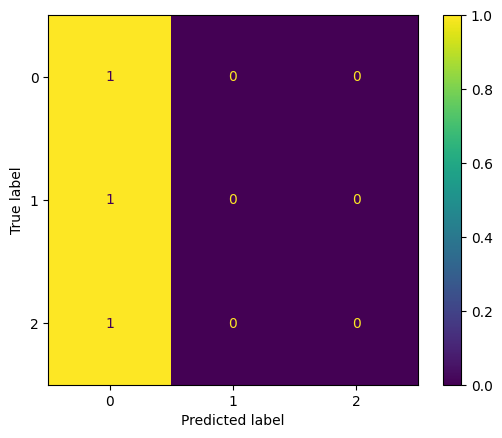

In [164]:
print_accuracy(agent.model.predict_accumulated_goodness(x_test.to(device)), y_test)

#### Frozen Lake

In [7]:
layers = [20,100,100,100]
threshold = 0.5
lr = 0.001

#RL hyperparameters
episodes = 2000
epsilon = 0.99
epsilon_decay = epsilon / (episodes / 2)
discount_factor = 0.9
batch_size = 32
update_td_target = 10
buffer_size = 1000

env = gym.make("FrozenLake-v1", max_episode_steps=100, desc=None, map_name="4x4", is_slippery=False)
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=episodes)


total_rewards = []
for i in range(5):
    print(f"\nRun {i+1}")
    print("-"*40)
    agent = DQFFNNAgent(
        env,
        device=device,
        layers=layers,
        threshold=threshold,
        lr=lr,
        epsilon=epsilon,
        epsilon_decay=epsilon_decay,
        discount_factor=discount_factor,
        batch_size=batch_size,
        update_td_target=update_td_target,
        buffer_size=buffer_size
    )

    play_game(env, episodes, agent, False, False, True)
    rewards = np.array(env.return_queue).flatten()
    total_rewards.append(rewards)

average_reward = sum(rewards)/episodes
variance = sum([((x - average_reward) ** 2) for x in rewards]) / (episodes - 1)
agent.model.save_model(path='../models/FrozenLake_DQFFNN_model.pth')

#print("Rewards: ", rewards)
# print("Average Reward: ", average_reward)
# print("Variance: ", variance)
plot_reward(total_rewards, "FrozenLake", f"FrozenLake_DQFFNN_agent_lr={lr}_df={discount_factor}_batch={batch_size}_update={update_td_target}_buffer={buffer_size}", ["Frozen Lake"],plot_variance=True , rolling_length=50)


Run 1
----------------------------------------


  4%|▍         | 84/2000 [00:05<02:12, 14.50it/s]


KeyboardInterrupt: 